# Problem 2. Classification

In [20]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


In [21]:
train_data = pd.read_csv("training.csv")
val_data = pd.read_csv("testing.csv")
test_data = pd.read_csv("validation.csv")

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
col_to_predict = "class"

def split_data(df:pd.DataFrame) -> pd.DataFrame:
    X_cols = df.columns.to_list()
    X_cols.remove(col_to_predict)
    X = df[X_cols]
    Y = df[col_to_predict].astype("category")
    return X, Y

X_train, Y_train = split_data(train_data)
X_val, Y_val = split_data(val_data)
X_test, Y_test = split_data(test_data)

print("====split data====")
print(X_train.shape)
print(Y_train.shape)
print(Y_train)
X_train.head()



(198, 28)
(161, 28)
(164, 28)
====split data====
(198, 27)
(198,)
0      d 
1      h 
2      s 
3      s 
4      d 
       ..
193    d 
194    d 
195    h 
196    h 
197    h 
Name: class, Length: 198, dtype: category
Categories (4, object): ['d ', 'h ', 'o ', 's ']


,b1,b2,b3,b4,b5,b6,b7,b8,b9,pred_minus_obs_H_b1,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,39,36,57,91,59,101,93,27,60,75.70,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,84,30,57,112,51,98,92,26,62,30.58,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,53,25,49,99,51,93,84,26,58,63.20,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,59,26,49,103,47,92,82,25,56,55.54,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,57,49,66,103,64,106,114,28,59,59.44,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


## Standardize Data

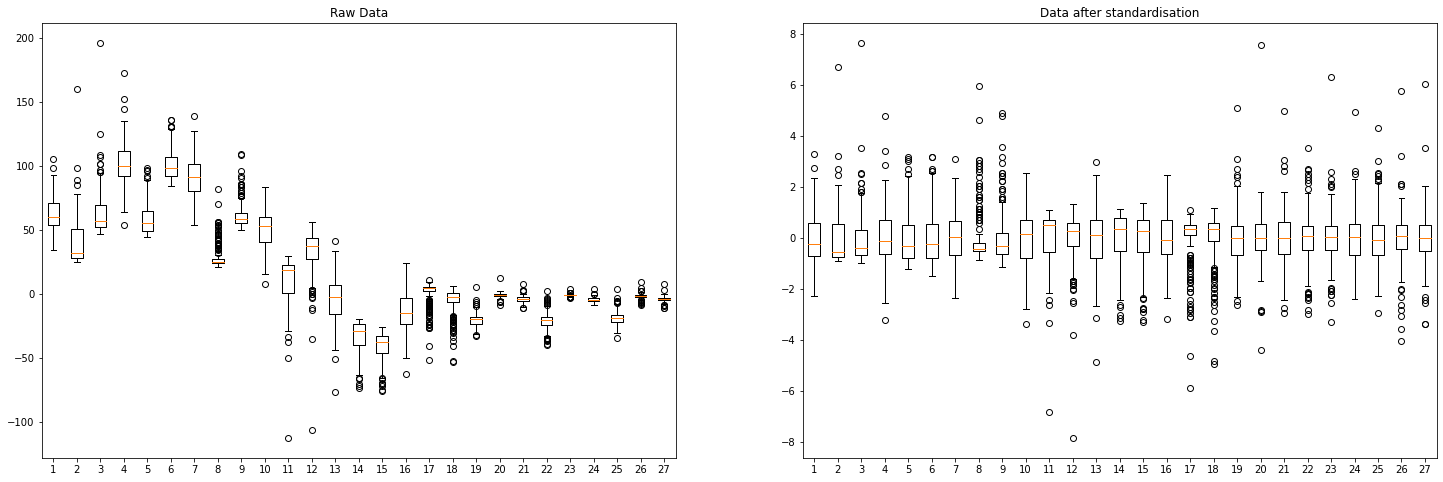

In [22]:
# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X_train)
ax.set_title('Raw Data')


scaler = StandardScaler()
scaler.fit(X_train)

s_X_train =pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
s_X_val =pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
s_X_test =pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(s_X_train)
ax.set_title('Data after standardisation');


Having a look at class imbalance

(array([54.,  0.,  0., 48.,  0.,  0., 59.,  0.,  0., 37.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

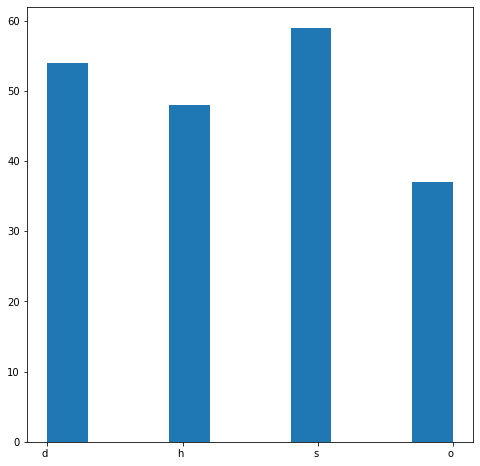

In [23]:
    fig = plt.figure(figsize=[8, 8])
    axe = fig.add_subplot(1,1,1)
    axe.hist(Y_train)


## Eval Function

In [24]:
def eval_model(model, X_train, Y_train,X_val, Y_val ,X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 3, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 3, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_val, Y_val, normalize='true', ax=ax)
    pred = model.predict(X_val)
    conf.ax_.set_title('Validation Set Performance: ' + str(sum(pred == Y_val)/len(Y_val)));

    ax = fig.add_subplot(1, 3, 3)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    

## K-Nearest Neighbours Classifier


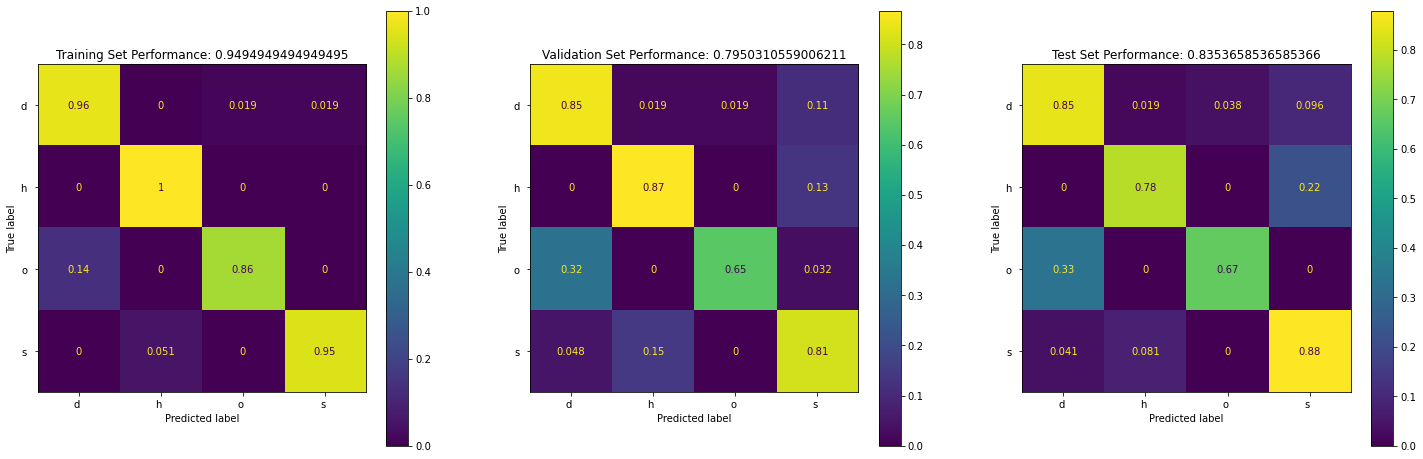

In [25]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
cknn.fit(s_X_train, Y_train)
eval_model(cknn, s_X_train, Y_train, s_X_val, Y_val,s_X_test, Y_test)

In [26]:
cknn = KNeighborsClassifier()
params = {'n_neighbors' : list(range(1,21)), 'weights' : ['uniform', 'distance']}
rand_search = RandomizedSearchCV(cknn, params, n_iter=20)
rand_search.fit(s_X_train, Y_train)
print(rand_search.cv_results_)

{'mean_fit_time': array([0.00348744, 0.00311441, 0.0033587 , 0.00359101, 0.00253472,
       0.00366678, 0.00280552, 0.0040081 , 0.00285978, 0.00292282,
       0.00216393, 0.00271201, 0.00229578, 0.00213666, 0.00244761,
       0.00268579, 0.00237637, 0.00217261, 0.00318069, 0.00312467]), 'std_fit_time': array([0.00075817, 0.00020602, 0.00061364, 0.00078326, 0.00017941,
       0.00066157, 0.00040046, 0.00120411, 0.00054681, 0.00022528,
       0.00014708, 0.0005731 , 0.00029262, 0.00025185, 0.00043354,
       0.00097428, 0.00023561, 0.00032772, 0.00056752, 0.00062915]), 'mean_score_time': array([0.00346656, 0.00568476, 0.00388074, 0.00504603, 0.00466075,
       0.00533857, 0.00317316, 0.00503693, 0.00343194, 0.00406942,
       0.00298867, 0.00305901, 0.00395069, 0.00222626, 0.00371151,
       0.00266109, 0.0025033 , 0.00244207, 0.0046134 , 0.0045918 ]), 'std_score_time': array([4.55362994e-04, 1.51427496e-03, 6.04754937e-04, 5.90194309e-04,
       8.84075247e-04, 1.40241820e-03, 4.4659773

{'weights': 'distance', 'n_neighbors': 1}


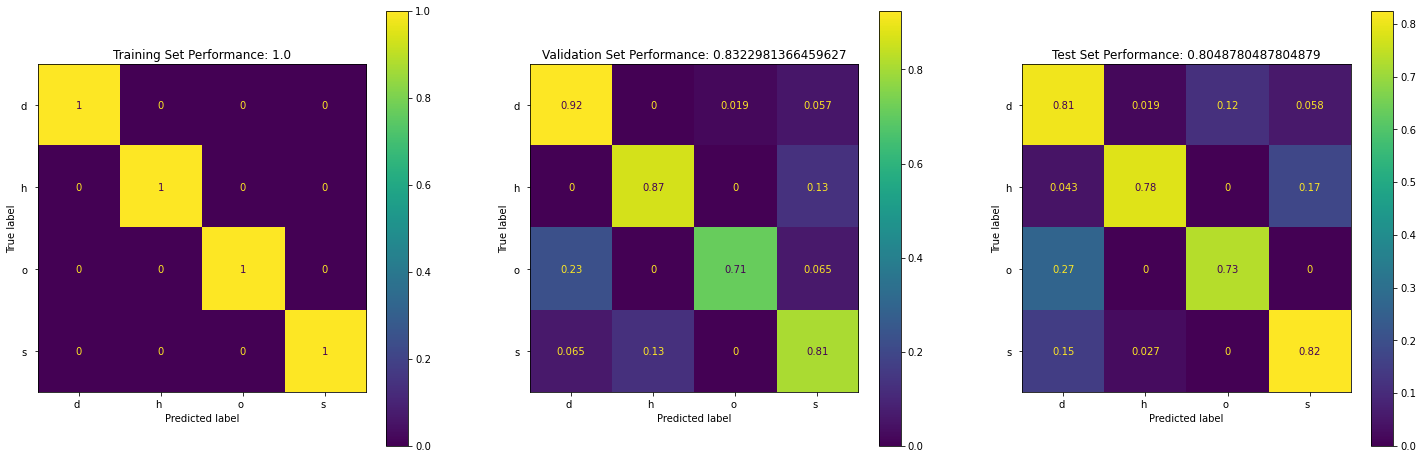

In [27]:
best_system = numpy.argmin(rand_search.cv_results_['rank_test_score'])
params = rand_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(s_X_train, Y_train)
eval_model(cknn, s_X_train, Y_train, s_X_val, Y_val, s_X_test, Y_test)

## Random Forest

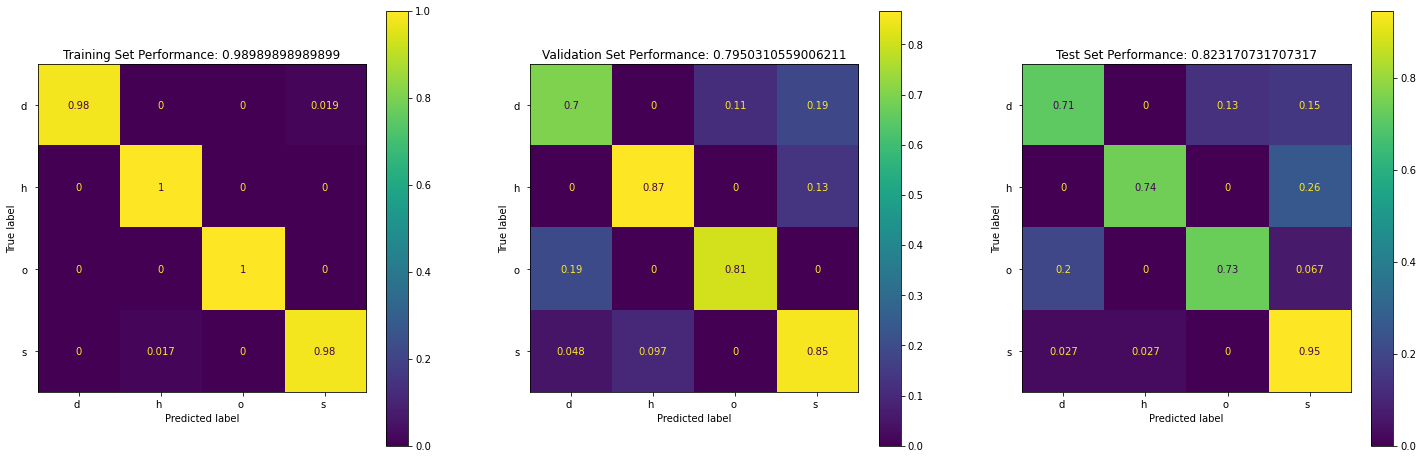

In [28]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
rf.fit(s_X_train, Y_train)
eval_model(rf, s_X_train, Y_train, s_X_val, Y_val, s_X_test, Y_test)

In [29]:
rf = RandomForestClassifier(random_state=42)
param_grid = {'max_depth': [2, 4, None], 'min_samples_split': [5, 10], 'n_estimators' : [25, 50, 100]}
halving_search = HalvingGridSearchCV(rf, param_grid, random_state=0).fit(s_X_train, Y_train)
print(halving_search.cv_results_)

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1]), 'n_resources': array([ 40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
        40,  40,  40,  40,  40, 120, 120, 120, 120, 120, 120]), 'mean_fit_time': array([0.041289  , 0.06254544, 0.12302437, 0.03725734, 0.06763096,
       0.12341995, 0.03709073, 0.0669311 , 0.13917909, 0.0353756 ,
       0.06610746, 0.12158294, 0.03434052, 0.06348028, 0.12533393,
       0.03423529, 0.06245265, 0.12230248, 0.07381177, 0.03469586,
       0.14141512, 0.17453461, 0.03511963, 0.03661799]), 'std_fit_time': array([0.00607943, 0.00099002, 0.0043881 , 0.00539969, 0.00547158,
       0.00241468, 0.00442303, 0.00579648, 0.02383333, 0.0037224 ,
       0.00189738, 0.00340534, 0.0024087 , 0.00422319, 0.00399492,
       0.00273213, 0.00136403, 0.0036811 , 0.01044018, 0.00123259,
       0.00928569, 0.04307532, 0.00208943, 0.00114969]), 'mean_score_time': array([0.0066782 , 0.00742559, 0.01255631, 0.00532

{'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 25}


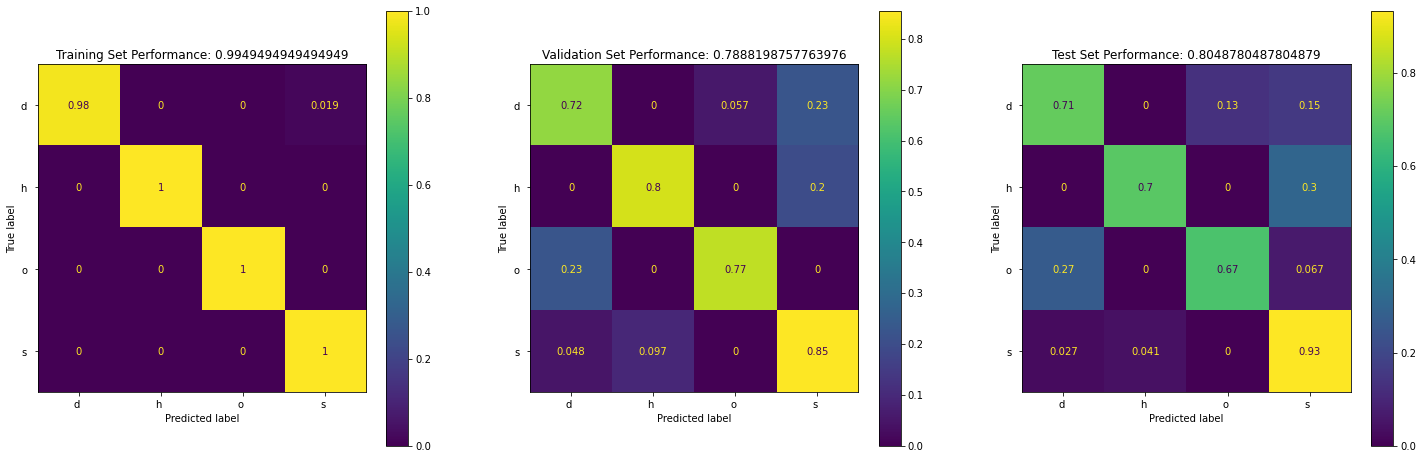

In [30]:
print(halving_search.cv_results_['params'][-1])
rf = RandomForestClassifier(random_state=42).set_params(**halving_search.cv_results_['params'][-1])
rf.fit(s_X_train, Y_train)
eval_model(rf, s_X_train, Y_train, s_X_val, Y_val, s_X_test, Y_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, rf.predict(s_X_test)))

              precision    recall  f1-score   support

          d        0.86      0.71      0.78        52
          h        0.84      0.70      0.76        23
          o        0.59      0.67      0.62        15
          s        0.81      0.93      0.87        74

    accuracy                           0.80       164
   macro avg       0.78      0.75      0.76       164
weighted avg       0.81      0.80      0.80       164



## An ensemble of Support Vector Machines.

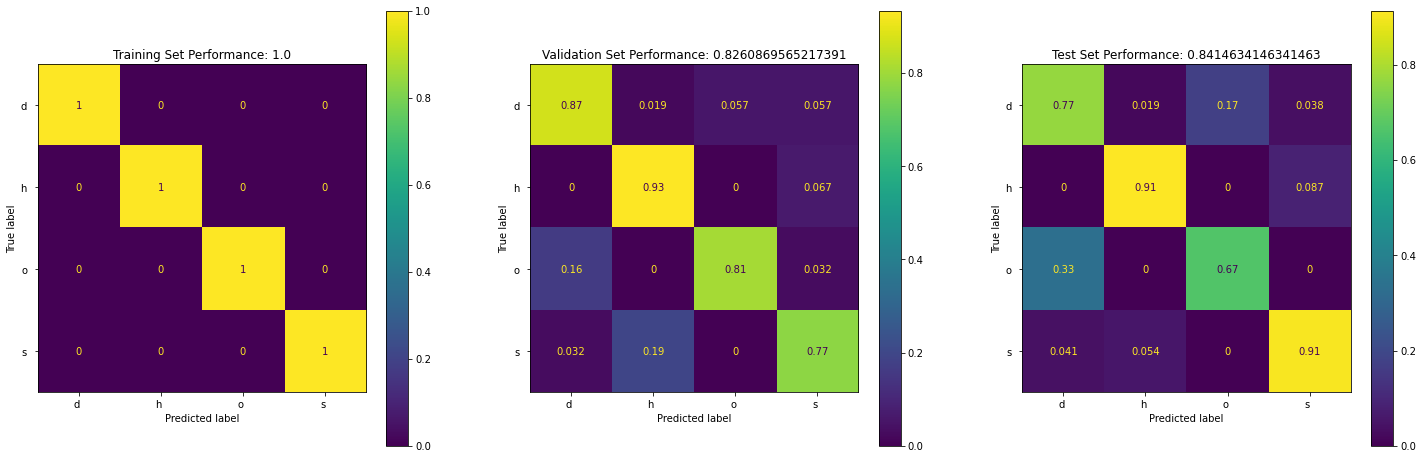

In [33]:
svm = SVC(C=1.0, kernel='linear')
svm.fit(s_X_train, Y_train)
eval_model(svm, s_X_train, Y_train, s_X_val, Y_val, s_X_test, Y_test)

In [34]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(s_X_train, Y_train)
grid_search.cv_results_

{'mean_fit_time': array([0.00463076, 0.00494599, 0.00411739, 0.00386829, 0.00322909,
        0.00470843, 0.00406585, 0.00411482, 0.00458755, 0.00435848,
        0.00351892, 0.0038085 , 0.00386086, 0.00446186, 0.00313182,
        0.00312605, 0.00383291, 0.00435119, 0.00294952, 0.00320873,
        0.00331306, 0.00413661, 0.00286622, 0.00333896, 0.0034256 ,
        0.00396228, 0.0040359 , 0.00367203, 0.00408354, 0.00499816,
        0.00408106, 0.00555668, 0.00541415, 0.00412269, 0.00587044,
        0.00425587, 0.00631752, 0.00360794, 0.00359416, 0.00400982,
        0.00494947, 0.00321894, 0.00352993, 0.00315347, 0.00369787]),
 'std_fit_time': array([0.00102433, 0.00105822, 0.00061393, 0.00100406, 0.00019315,
        0.00124892, 0.0001571 , 0.00020047, 0.00067206, 0.00056576,
        0.00024269, 0.00020349, 0.00018098, 0.00034862, 0.00036833,
        0.00014415, 0.00020306, 0.00022197, 0.00022043, 0.00031189,
        0.000435  , 0.00019179, 0.00018682, 0.00011029, 0.00043752,
        0.000

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


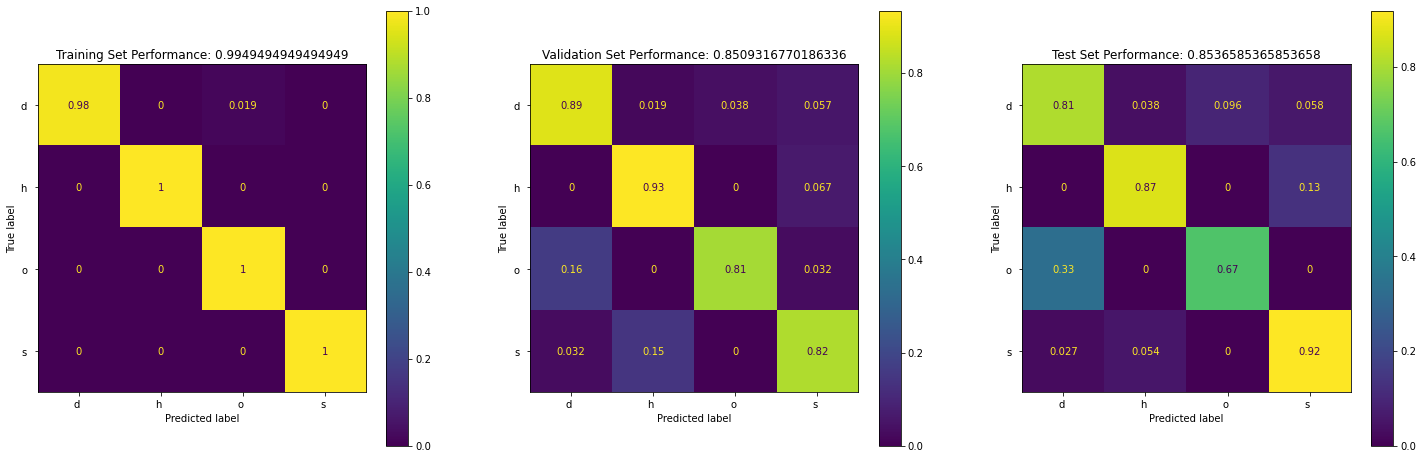

In [35]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(s_X_train, Y_train)
eval_model(svm, s_X_train, Y_train, s_X_val, Y_val, s_X_test, Y_test)